### Introduction to ML through the Titanic dataset on Kaggle

The intention of this notebook is neither to achieve the best score nore to present the most efficient code, but to  walk the first steps in the Machine Learning path. Hence, instead of presenting a well structured notebook with colorful visualizations and detailed explanations I will just present what I've learned so far with some notes in the points I deem interesting.

Because of the above, there's a lot of room for improvement so I might come in the future to give another go to the project. At the time of the submission, this notebook yielded an accuracy of 0.78947 as per the competition's leaderboard.

I'd like to attach some links of kernels I found interesting because of the ideas they present (feature engineering, predictive models used, etc.):

https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
Not a 99% accuracy kernel, but a comprehensive guide for data science beginners.

https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
A kernel that introduces the concept of Ensembling/Stacking, a method responsible for many a team winning Kaggle competitions.

In [1]:
#Importing the libraries that we are going to use:

import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [2]:
#Reading the train / test data:

train_data = pd.read_csv('/../Titanic/train.csv')
test_data = pd.read_csv('/../Titanic/test.csv')

FileNotFoundError: File b'/../Titanic/train.csv' does not exist

In [5]:
#Let's take a general look to our data:

train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Murphy, Miss. Margaret Jane",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
train_data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
397,398,0,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S
80,81,0,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,NaN,S
91,92,0,3,"Andreasson, Mr. Paul Edvin",male,20.0,0,0,347466,7.8542,NaN,S
668,669,0,3,"Cook, Mr. Jacob",male,43.0,0,0,A/5 3536,8.0500,NaN,S


In [8]:
#As we are browsing through our data, we can have a look at the correlation between features:

train_data.corr()

#Is worth to mention that there are a lot of informative plots to easily detect trends among features (for example, 
#heat maps).

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [9]:
#We can also check the impact of diferent features in the survival probability:
print (train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [10]:
print (train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [11]:
#Let's find out which columns have missing values on both files:

print('Train columns with null values:\n', train_data.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


To deal with missing values, we have 3 options: drop columns, impute a value or impute a value with extension (adding a new column to represent in which lines the values were missing). It's important to consider how many rows of each feature have missing values. Embarked (the code of the embarking port) have 2 missing values, whereas Cabin have 687 and Age 177.

The data type of the Cabin column is 'object', and since it has that many missing values, we'll just drop the column. Among other reasons, more than half the rows have missing values, and we don't have any method to infere the cabin code to impute them.

In the Embarked column we just have 2 missing values. Since its data type is object and we just have 3 categories, we'll impute the mode.

Lets dig a little bit more to decide what to do with 'Age'.

#### Important note:
Even though the 'imputation with extension' method (including extra columns showing what was imputed) is explained on the Kaggle ML tutorial, is worth mentioning that I haven't seen it applied in any of the various kernels reviewed. I have applied this method anyway for practicing purposes.

(array([14., 10.,  6., 10.,  7.,  3.,  4.,  8.,  2.,  4.,  1.,  8.,  6.,
        17., 13., 26., 25., 16., 51., 15., 31., 24., 18., 18., 27., 20.,
        44., 18., 17., 16., 18., 23.,  6., 25., 13.,  8., 13.,  5.,  9.,
        14., 12.,  9.,  6., 10.,  7.,  6.,  1.,  8.,  7.,  2.,  5.,  2.,
         4.,  3.,  4.,  4.,  3.,  1.,  0.,  0.,  0.,  3.,  2.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.]),
 array([ 0.42      ,  1.55685714,  2.69371429,  3.83057143,  4.96742857,
         6.10428571,  7.24114286,  8.378     ,  9.51485714, 10.65171429,
        11.78857143, 12.92542857, 14.06228571, 15.19914286, 16.336     ,
        17.47285714, 18.60971429, 19.74657143, 20.88342857, 22.02028571,
        23.15714286, 24.294     , 25.43085714, 26.56771429, 27.70457143,
        28.84142857, 29.97828571, 31.11514286, 32.252     , 33.38885714,
        34.52571429, 35.66257143, 36.79942857, 37.93628571, 39.07314286,
        40.21      , 41.34685714, 42.48371429, 43.62057143, 44.75742857,
        45.89428

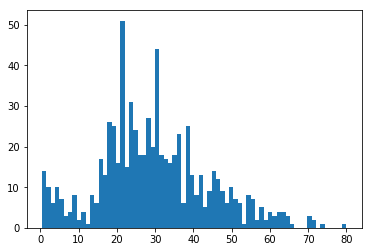

In [12]:
#Let's have a look to the 'Age' data, dropping de nan values and ploting an histogram to get an idea of its distribution.

plt.hist(train_data['Age'].dropna(), bins = 70)

Nothing seems to indicate otherwise so we will assume the age feature follows a normal distribution.

### Data cleaning: correcting, completing, creating and converting

From the insights we got inspecting the data, for this 1st submission attempt we have taken the following decissions:

- We will drop the Cabin, ticket and Name features. A note for future consideration: with feature engineering from the Name column we could extract the sex of the passenger, its title and as a derivate from it, its socio-economic status (SES).

- We will impute the mode for the embarked missing values

- We will impute the mean for the Fare missing value on the test dataset

- We will impute the mean for the Age missing values. Instead of just imputing a statistic, there are some alternatives:
    · Imputing the mean + random noise using standar deviation.
    · A refined imputer method considering the high correlation showed with other features. Example: some kernels use Pclass as a point of reference. For the missing values of passengers belonging to a certain Pclass, we could apply the above method extracting the statistics from that subgroup.
    
Other possibilities for feature engineering could be to create a variable extracting the title from the Name and codifying it as a categorical value, creating a feature with the family size (inferred from the SibSp and Parch variables) or to create a variable showing if a passenger travels alone (expressed as a lack of realitves aboard). In some of the reviewed kernels, the features 'Age' and 'Fare' where transformed using the pd.qcut and pd.cut functions to divide them into ranges as a way to reduce the noise.

On a side note, none of the kernels reviewed included the 'PassengerId' as a feature for the models but we'll not drop the column because the models where tested prior to investigating other solutions.

In [13]:
mod_traind = train_data.copy()
mod_testd = test_data.copy()

In [14]:
mod_traind.drop(['Cabin', 'Ticket', 'Name'], inplace=True, axis=1)
mod_testd.drop(['Cabin', 'Ticket', 'Name'], inplace=True, axis=1)

In [15]:
#As we will use the 'imputation with extension' method for both Age and Embarked
#we will first create the 'was missing' columns.

mod_traind['Age_was_missing'] = mod_traind['Age'].isnull()
mod_testd['Age_was_missing'] = mod_testd['Age'].isnull()
mod_traind['Embarked_was_missing'] = mod_traind['Embarked'].isnull()
mod_testd['Embarked_was_missing'] = mod_testd['Embarked'].isnull()

In [16]:
mod_traind['Age'] = SimpleImputer().fit_transform(mod_traind[['Age']])
mod_testd['Age'] = SimpleImputer().fit_transform(mod_testd[['Age']])
mod_traind['Embarked'] = SimpleImputer(strategy='most_frequent').fit_transform(mod_traind[['Embarked']])
mod_testd['Embarked'] = SimpleImputer(strategy='most_frequent').fit_transform(mod_testd[['Embarked']])
mod_testd['Fare'] = SimpleImputer().fit_transform(mod_testd[['Fare']])

In [17]:
#A quick check to see if everything is OK:
print(mod_traind.isnull().any(), mod_testd.isnull().any())

PassengerId             False
Survived                False
Pclass                  False
Sex                     False
Age                     False
SibSp                   False
Parch                   False
Fare                    False
Embarked                False
Age_was_missing         False
Embarked_was_missing    False
dtype: bool PassengerId             False
Pclass                  False
Sex                     False
Age                     False
SibSp                   False
Parch                   False
Fare                    False
Embarked                False
Age_was_missing         False
Embarked_was_missing    False
dtype: bool


The only step left prior to implementing the models would be to transform the categorical data into a suitable format for the ML learning models. To transform these features to numeric variables there are methods such as One-Hot Encoding.

Even though the encoding algorithms are fairly easy to use, we will encode the 'Sex' data manually:

In [18]:
#In order to make the changes inplace we can use a for loop:
for e in range(len(mod_traind['Sex'])):
    if mod_traind['Sex'][e] == 'male':
        mod_traind['Sex'][e] = 0
    else: 
        mod_traind['Sex'][e] = 1
        
for e in range(len(mod_testd['Sex'])):
    if mod_testd['Sex'][e] == 'male':
        mod_testd['Sex'][e] = 0
    else: 
        mod_testd['Sex'][e] = 1

/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/h

In [19]:
mod_traind.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_was_missing,Embarked_was_missing
0,1,0,3,0,22.0,1,0,7.2500,S,False,False
1,2,1,1,1,38.0,1,0,71.2833,C,False,False
2,3,1,3,1,26.0,0,0,7.9250,S,False,False
3,4,1,1,1,35.0,1,0,53.1000,S,False,False
4,5,0,3,0,35.0,0,0,8.0500,S,False,False


In [20]:
#As we can see, the values have changed, but have the data type changed as well?
#Let's find out:
mod_traind.dtypes

PassengerId               int64
Survived                  int64
Pclass                    int64
Sex                      object
Age                     float64
SibSp                     int64
Parch                     int64
Fare                    float64
Embarked                 object
Age_was_missing            bool
Embarked_was_missing       bool
dtype: object

In [21]:
#ALERT: even though we have changed the values in the 'Sex' feature, the dtype is still object. 
#If we apply the OHE method now, it will take Sex as a dummy (even having been encoded to 0 & 1),
#so we have to transform its data type before the OHE process.
mod_traind['Sex'] = pd.to_numeric(mod_traind['Sex'])
mod_testd['Sex'] = pd.to_numeric(mod_testd['Sex'])
mod_traind.dtypes

PassengerId               int64
Survived                  int64
Pclass                    int64
Sex                       int64
Age                     float64
SibSp                     int64
Parch                     int64
Fare                    float64
Embarked                 object
Age_was_missing            bool
Embarked_was_missing       bool
dtype: object

In [22]:
mod_traind_ohe = pd.get_dummies(mod_traind)
mod_testd_ohe = pd.get_dummies(mod_testd)
mod_testd_ohe.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Age_was_missing,Embarked_was_missing,Embarked_C,Embarked_Q,Embarked_S
181,1073,1,0,37.00000,1,1,83.1583,False,False,1,0,0
72,964,3,1,29.00000,0,0,7.9250,False,False,0,0,1
48,940,1,1,60.00000,0,0,76.2917,False,False,1,0,0
185,1077,2,0,40.00000,0,0,16.0000,False,False,0,0,1
199,1091,3,1,30.27259,0,0,8.1125,True,False,0,0,1


## The first approach to prepare our data is ready. Let's try some models

Prior to the design of our models, since the Kaggle dataset doesn't supply the column Survived in the test data, we will split our train data to test the effectiveness of one model or another. To avoid bias, we will first randomize the entries and afterwards we will do the split.

There are algorithms designed for the split train/test functionality, but again we will do it manually for the sake of practice. We will establish the random seed at 42 for reproducibility.

#### Important note:
Another strategy used to test the accuracy of the models used is the Cross Validation method. Is more time-consuming and intense in terms of computer resources but is most recommended for small dataset such as the one we are using for this project. Might be worth to try cross-validation in the future.

In [71]:
random_index_list = [x for x in range(len(mod_traind_ohe))]
np.random.seed(42)
np.random.shuffle(random_index_list)
data = mod_traind_ohe

In [72]:
#We will reorganize the columns in order to split X and y (the same way the columns of the test data are organized):
cols = mod_traind_ohe.columns.tolist()
cols_sorted = [cols[1]] + [cols[0]] + cols[2:]
data = mod_traind_ohe[cols_sorted].values
data = data[random_index_list]

In [73]:
#We'll assign 600 entries for train and the rest for test. Afterwards, we will split between X and y.
x_train, x_test = np.array(data[:600]), np.array(data[600:])
separate = lambda x: (x[:,1:], x[:,0])
x_train, y_train = separate(x_train)
x_test, y_test = separate(x_test)

Now we have our original train data separated into x_train, y_train, x_test and y_test.

### Let the fun begin

#### Decision Tree Model

In [26]:
titanic_tree = DecisionTreeRegressor(random_state=1)
titanic_tree.fit(x_train, y_train)
val_tree_predictions = titanic_tree.predict(x_test)

In [27]:
#Let's check our predictions. This is important, because we want a binary classifier (either 0 or 1) but the
#outpu of some models will be values in between (or even above of 1 or below of 0).
val_tree_predictions[:10]

array([0., 1., 1., 0., 0., 0., 1., 1., 1., 0.])

In [28]:
val_mae = mean_absolute_error(y_test, val_tree_predictions)
counter_difpreds = 0
for e in range(len(val_tree_predictions)):
    if val_tree_predictions[e] != y_test[e]:
        counter_difpreds += 1
print('Validations MAE:  {} / 291 = {}'.format(counter_difpreds, val_mae))

Validations MAE:  73 / 291 = 0.2508591065292096


Without further changes, this model has already almost a 75% of accuracy. Let's try to find the maximum number of leaf nodes that gives the best accuracy:

In [29]:
def get_mae(max_leaf_nodes, x_train, x_test, y_train, y_test):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(x_train, y_train)
    preds_val = model.predict(x_test)
    mae = mean_absolute_error(y_test, preds_val)
    return(mae)

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
nodes_mae = []
for _ in candidate_max_leaf_nodes:
    leafs_mae = get_mae(_, x_train, x_test, y_train, y_test)
    print(('Max_leaf_nodes: {}\t\t Mean Absolute error: {}').format(_,leafs_mae))
    nodes_mae.append([_, leafs_mae])

# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = min(nodes_mae, key = lambda x: x[1])[0] 

Max_leaf_nodes: 5		 Mean Absolute error: 0.2851296836465368
Max_leaf_nodes: 25		 Mean Absolute error: 0.26173845115122657
Max_leaf_nodes: 50		 Mean Absolute error: 0.2474062612045138
Max_leaf_nodes: 100		 Mean Absolute error: 0.25773343555017925
Max_leaf_nodes: 250		 Mean Absolute error: 0.2508591065292096
Max_leaf_nodes: 500		 Mean Absolute error: 0.2508591065292096


In [30]:
titanic_best_tree = DecisionTreeRegressor(max_leaf_nodes = 50, random_state = 1)
titanic_best_tree.fit(x_train, y_train)
best_tree_predictions = titanic_best_tree.predict(x_test)
best_tree_predictions[:10]

array([0.10619469, 1.        , 0.10619469, 0.05833333, 0.        ,
       0.10619469, 1.        , 0.88235294, 1.        , 0.10619469])

#### ALERT!!!

After adjusting the size of the tree, the first thing we realize is that the predicted values have changed to values between 0 and 1. From what we've read, there must be a way to specify the need of a binary output in our predictions.

Since we've not deeply explored the models, for the time being we will format the results rounding them to 0 or 1 in order to compare our results with y_test. This is NOT an optimal method, and we're not sure if it's a correct one for that matter.

In [31]:
btp_mod = []
for e in best_tree_predictions:
    if e < 0.5:
        btp_mod.append(0)
    else:
        btp_mod.append(1)
        
val_mae_besttree = mean_absolute_error(y_test, btp_mod)
counter_difpreds = 0
for e in range(len(btp_mod)):
    if btp_mod[e] != y_test[e]:
        counter_difpreds += 1
print('Validations MAE:  {} / 291 = {}'.format(counter_difpreds, val_mae_besttree))

Validations MAE:  57 / 291 = 0.1958762886597938


#### Random Forest Model

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_val_mae = mean_absolute_error(y_test,rf_model.predict(x_test))

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 0.2649484536082474


/home/dsc/anaconda3/envs/kschool/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
rf_predictions[:10]

array([0. , 1. , 0.3, 0. , 0.6, 0. , 0.1, 1. , 1. , 0. ])

Unlike the predictions with the regression tree, we observe that the predictions with the random forest give a float of just 1 decimal. Let's try and adjust these values the same way we did with the results of the tree decision plus (with max_leaf_nodes adjusted) to make the comparison with y_test.

In [34]:
rf_mod_predictions = []
for e in rf_predictions:
    if e < 0.5:
        rf_mod_predictions.append(0)
    else:
        rf_mod_predictions.append(1)

val_mae_bestforest = mean_absolute_error(y_test, rf_mod_predictions)
counter_difpreds = 0
for e in range(len(rf_mod_predictions)):
    if rf_mod_predictions[e] != y_test[e]:
        counter_difpreds += 1
print('Validations MAE:  {} / 291 = {}'.format(counter_difpreds, val_mae_bestforest))

Validations MAE:  62 / 291 = 0.21305841924398625


#### XGBoost model

In [45]:
#!pip install xgboost
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [48]:
xgb_predictions = xgb_model.predict(x_test)
xgb_predictions[:10]

array([0.14953312, 1.1493738 , 0.14689901, 0.08344692, 0.45340788,
       0.0792416 , 0.36567178, 0.7491114 , 0.8322771 , 0.15896991],
      dtype=float32)

In [49]:
xgb_mod_pred = []
for i in range(len(x_test)):
    if xgb_predictions[i] < 0.5:
        xgb_mod_pred.append(0)
    else:
        xgb_mod_pred.append(1)
        
val_mae_xgbmodel = mean_absolute_error(y_test, xgb_mod_pred)
counter_difpreds = 0
for e in range(len(xgb_mod_pred)):
    if xgb_mod_pred[e] != y_test[e]:
        counter_difpreds += 1
print('Validations MAE:  {} / 291 = {}'.format(counter_difpreds, val_mae_xgbmodel))

Validations MAE:  53 / 291 = 0.18213058419243985


#### XGBoost with model tuning

There are some parameters, as the n_estimators, which we can adjust to reach a better performance. As learned from the ML Kaggle course, we'll find the n_estimators that better perform with 10 early_stopping_rounds.

In [74]:
xgbplus_model = XGBRegressor(n_estimators=1000)
xgbplus_model.fit(x_train, y_train, early_stopping_rounds=10,
                 eval_set=[(x_test, y_test)], verbose=True)

[0]	validation_0-rmse:0.477032
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.458828
[2]	validation_0-rmse:0.441986
[3]	validation_0-rmse:0.429146
[4]	validation_0-rmse:0.418603
[5]	validation_0-rmse:0.409471
[6]	validation_0-rmse:0.402055
[7]	validation_0-rmse:0.396874
[8]	validation_0-rmse:0.390633
[9]	validation_0-rmse:0.384916
[10]	validation_0-rmse:0.38223
[11]	validation_0-rmse:0.378658
[12]	validation_0-rmse:0.375418
[13]	validation_0-rmse:0.373405
[14]	validation_0-rmse:0.371255
[15]	validation_0-rmse:0.369365
[16]	validation_0-rmse:0.367792
[17]	validation_0-rmse:0.3664
[18]	validation_0-rmse:0.365769
[19]	validation_0-rmse:0.365443
[20]	validation_0-rmse:0.365345
[21]	validation_0-rmse:0.365086
[22]	validation_0-rmse:0.363967
[23]	validation_0-rmse:0.36404
[24]	validation_0-rmse:0.363726
[25]	validation_0-rmse:0.363648
[26]	validation_0-rmse:0.363812
[27]	validation_0-rmse:0.363808
[28]	validation_0-rmse:0.363981
[29]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [75]:
xgbplus_tunned_model = XGBRegressor(n_estimators=36)
xgbplus_tunned_model.fit(x_train, y_train, verbose=False)
xgbplus_tunned_predictions = xgbplus_tunned_model.predict(x_test)

In [76]:
xgbplus_mod_tunned_pred = []
for i in range(len(x_test)):
    if xgbplus_tunned_predictions[i] < 0.5:
        xgbplus_mod_tunned_pred.append(0)
    else:
        xgbplus_mod_tunned_pred.append(1)

val_mae_xgbplusmodel = mean_absolute_error(y_test, xgbplus_mod_tunned_pred)
counter_difpreds = 0
for e in range(len(xgbplus_mod_tunned_pred)):
    if xgbplus_mod_tunned_pred[e] != y_test[e]:
        counter_difpreds += 1
print('Validations MAE:  {} / 291 = {}'.format(counter_difpreds, val_mae_xgbplusmodel))

Validations MAE:  54 / 291 = 0.18556701030927836


The performance is worse than the 'base' model as per our measure.

#### Multivariable regression model

##### Disclaimer:
Not sure this would be considered a ML model. We implemented the mutlivariable regression model in the Introduction to Statistics course as a way to introduce us to autograd. From that, it was recommended to explore tensorflow and keras.

In [35]:
#!pip install autograd
import autograd.numpy as np
from autograd import grad

In [40]:
def f_mod(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, 
         a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12):
    return a0 + a1*x1 + a2*x2 + a3*x3 + a4*x4 + a5*x5 + a6*x6 + a7*x7 + a8*x8 + a9*x9 + a10*x10 + a11*x11 + a12*x12

def Loss(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12,
         a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, y):
    return np.sum(np.square(f_mod(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12,
         a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12) - y), axis = 0)

d_Loss_a0 = grad(Loss, argnum=14)
d_Loss_a1 = grad(Loss, argnum=15)
d_Loss_a2 = grad(Loss, argnum=16)
d_Loss_a3 = grad(Loss, argnum=17)
d_Loss_a4 = grad(Loss, argnum=18)
d_Loss_a5 = grad(Loss, argnum=19)
d_Loss_a6 = grad(Loss, argnum=20)
d_Loss_a7 = grad(Loss, argnum=21)
d_Loss_a8 = grad(Loss, argnum=22)
d_Loss_a9 = grad(Loss, argnum=23)
d_Loss_a9 = grad(Loss, argnum=24)
d_Loss_a10 = grad(Loss, argnum=25)
d_Loss_a11 = grad(Loss, argnum=26)
d_Loss_a12 = grad(Loss, argnum=27)



par_a_0 = 0.
par_a_1 = 0.
par_a_2 = 0.
par_a_3 = 0.
par_a_4 = 0.
par_a_5 = 0.
par_a_6 = 0.
par_a_7 = 0.
par_a_8 = 0.
par_a_9 = 0.
par_a_10 = 0.
par_a_11 = 0.
par_a_12 = 0.


learning_rate = 1e-10
tolerance = 10
max_iter = 1e3
cont = 0

while (tolerance < Loss(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train )):
    par_a_0 = par_a_0 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_1 = par_a_1 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_2 = par_a_2 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_3 = par_a_3 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_4 = par_a_4 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_5 = par_a_5 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_6 = par_a_6 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_7 = par_a_7 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_8 = par_a_8 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_9 = par_a_9 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_10 = par_a_10 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_11 = par_a_11 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_12 = par_a_12 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    par_a_13 = par_a_13 - learning_rate * d_Loss_a0(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train)
    cont += 1
    print(Loss(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7], x_train[:,8], x_train[:,9], x_train[:,10], x_train[:,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12, y_train ))
    if cont > max_iter:
        print('Maximum interations reached')
        break
print('Optimization result:\n\t y ='+ str(par_a_0) + ' + '+str(par_a_1)+'(x1) + '+str(par_a_2)+'(x2) + '+str(par_a_3)+'(x3) + '+str(par_a_4)+'(x4) + '+str(par_a_5)+'(x5) + '+str(par_a_6)+'(x6) + '+str(par_a_7)+'(x7) + '+str(par_a_8)+'(x8) + '+str(par_a_9)+'(x9) + '+str(par_a_10)+'(x10) + '+str(par_a_11)+'(x11) + '+str(par_a_12)+'(x12)' )

232.97801869310334
232.95604355189184
232.93407457466108
232.91211175970616
232.89015510532323
232.86820460980866
232.84626027145885
232.82432208857193
232.80239005944463
232.7804641823762
232.7585444556649
232.73663087760988
232.71472344651087
232.69282216066802
232.67092701838186
232.64903801795333
232.6271551576844
232.6052784358764
232.58340785083215
232.5615434008548
232.5396850842475
232.51783289931342
232.4959868443582
232.4741469176857
232.45231311760114
232.4304854424113
232.40866389042063
232.38684845993723
232.36503914926783
232.34323595671955
232.32143888060074
232.29964791921984
232.277863070886
232.25608433390875
232.23431170659754
232.21254518726278
232.19078477421547
232.1690304657673
232.14728226022922
232.12554015591394
232.10380415113414
232.08207424420291
232.06035043343365
232.03863271714044
232.0169210936381
231.99521556124154
231.97351611826633
231.9518227630277
231.93013549384312
231.90845430902823
231.88677920690154
231.86511018578017
231.84344724398213
231.821

223.6676092887902
223.64824802983446
223.62889221171943
223.60954183293916
223.59019689198882
223.57085738736322
223.55152331755696
223.53219468106647
223.5128714763876
223.4935537020169
223.4742413564517
223.45493443818887
223.43563294572633
223.41633687756303
223.39704623219623
223.37776100812613
223.35848120385182
223.33920681787305
223.31993784869013
223.30067429480374
223.28141615471517
223.2621634269259
223.24291610993765
223.2236742022529
223.20443770237438
223.18520660880523
223.16598092004887
223.14676063460956
223.12754575099183
223.1083362676997
223.08913218323968
223.06993349611596
223.05074020483548
223.03155230790435
223.0123698038297
222.99319269111848
222.97402096827875
222.9548546338181
222.93569368624514
222.91653812406923
222.89738794579958
222.87824314994526
222.85910373501716
222.83996969952562
222.82084104198123
222.8017177608959
222.7825998547809
222.76348732214862
222.7443801615121
222.72527837138364
222.70618195027689
222.68709089670566
222.66800520918434
222.6

215.5851204227286
215.56803261479425
215.550949618172
215.5338714315288
215.51679805353248
215.49972948285125
215.48266571815245
215.4656067581052
215.4485526013786
215.4315032466408
215.41445869256296
215.397418937814
215.38038398106465
215.3633538209856
215.34632845624853
215.3293078855243
215.31229210748478
215.29528112080214
215.27827492414923
215.26127351619883
215.2442768956243
215.22728506109934
215.21029801129762
215.19331574489425
215.1763382605629
215.1593655569803
215.1423976328204
215.12543448675962
215.10847611747425
215.09152252364095
215.0745737039365
215.05762965703826
215.04069038162382
215.0237558763714
215.00682613995917
214.98990117106612
214.97298096837125
214.95606553055376
214.93915485629415
214.92224894427252
214.90534779316883
214.8884514016643
214.87155976844042
214.85467289217866
214.83779077156123
214.82091340527046
214.8040407919894
214.7871729304002
214.7703098191878
214.7534514570348
214.73659784262537
214.71974897464537
214.7029048517783
214.686065472709

In [42]:
#In order to try our model, we get the predictions from our X_test data to compare it with y_test
reg_mod_pred = []
for i in range(len(x_test)):
    if f_mod(x_test[i,0], x_test[i,1], x_test[i,2], x_test[i,3], x_test[i,4], x_test[i,5], x_test[i,6], x_test[i,7], x_test[i,8], x_test[i,9], x_test[i,10], x_test[i,11], par_a_0, par_a_1, par_a_2, par_a_3, par_a_4, par_a_5, par_a_6, par_a_7, par_a_8, par_a_9, par_a_10, par_a_11, par_a_12) < 0.5:
        reg_mod_pred.append(0)
    else:
        reg_mod_pred.append(1)

In [43]:
val_mae_regmodel = mean_absolute_error(y_test, reg_mod_pred)
counter_difpreds = 0
for e in range(len(reg_mod_pred)):
    if reg_mod_pred[e] != y_test[e]:
        counter_difpreds += 1
print('Validations MAE:  {} / 291 = {}'.format(counter_difpreds, val_mae_regmodel))

Validations MAE:  109 / 291 = 0.3745704467353952


##### Machine Learning scoring parameters

There are different scoring metrics to validate the quality of ML models. In our models we have measured the accuracy as number of correctly predicted outputs vs. total outputs. However, for statistical analysis of binary classification, there's an interesting method called 'F1 score' or 'F score'.

https://en.wikipedia.org/wiki/F1_score

As previously stated, the intent of this kernel is not to get into much detail about ML (methods, quality scores, etc.) so we are just pointing the scoring methods out for future consideration.

In terms of accuracy, with the feature engineering we have applied to our data the gression model is the one that yields better results so far.

### Prepare results for submission

In terms of accuracy, the model that yields the best results (for the dataset of the project and the data cleaning we have applied) is the XGBoost model.

Let's use it to submit our results.

In [63]:
data = mod_traind_ohe[cols_sorted].values
separate = lambda x: (x[:,1:], x[:,0])
x_train, y_train = separate(data)

X_test_data = mod_testd_ohe.values

In [64]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
xgb_predictions = xgb_model.predict(X_test_data)
Y_test = []
for i in range(len(X_test_data)):
    if xgb_predictions[i] < 0.5:
        Y_test.append(0)
    else:
        Y_test.append(1)

In [69]:
#We prepare a new dataframe with the results and check it to make sure it has the correct format:
submission_titanic = pd.DataFrame(np.hstack([np.array(mod_testd_ohe['PassengerId']).reshape(-1, 1), pd.DataFrame({'Survived': Y_test})]))
submission_titanic.columns = ['PassengerId', 'Survived']
submission_titanic.sample(10)

,PassengerId,Survived
208,1100,1
407,1299,0
117,1009,1
338,1230,0
165,1057,0
23,915,1
181,1073,0
74,966,1
84,976,0
389,1281,0


In [ ]:
submission_titanic.to_csv('titanic_submission.csv', index=False)